In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import pandas as pd
import deepmatcher as dm
from utils.explainer import generateExplanations
from utils.explainer import testRobustness
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
from utils.distance_measures import calculate_nearest_neighbors_onAttributes

In [4]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/itunes_amazon_hybrid.pth')

In [5]:
positives_nn = pd.read_csv('experiments/results/positives_nn_hybrid_withoutfilter.csv')
negatives = pd.read_csv('../../Structured/itunes-amazon/negatives.csv')

In [6]:
selected_attributes = ['Price','Song_Name','Time']

In [7]:
%%capture
critical_forPositives = {}
for att in selected_attributes:
    critical_values = generateExplanations(positives_nn,negatives,att,hybrid_model,10,0.03,
                                         '../../Structured/itunes-amazon/positives.csv',1)
    critical_forPositives[att] = critical_values

In [8]:
negatives_nn = pd.read_csv('experiments/results/negatives_nn_hybrid_withoutfilter.csv')
positives = pd.read_csv('../../Structured/itunes-amazon/positives.csv')

In [18]:
%%capture
critical_forNegatives = {}
for att in selected_attributes:
    critical_values = generateExplanations(negatives_nn,positives,att,hybrid_model,20,0.03,
                                         '../../Structured/itunes-amazon/negatives.csv',0)
    critical_forNegatives[att] = critical_values

In [20]:
for df,lval,rval in critical_forNegatives['Price']:
    print((lval,rval))

('$ 0.99', '$ 0.99')
('$ 1.29', '$ 1.29')


## Build new samples based on critical values

### Try first with 5% of each critical

In [10]:
from utils.newSamplesBuilder import buildNewSamplesForAttribute

In [15]:
train_df = pd.read_csv('../../Structured/itunes-amazon/merged_train.csv')
positives_len = train_df[train_df.label==1].shape[0]
negatives_len = train_df[train_df.label==0].shape[0]
len_validation = pd.read_csv('../../Structured/itunes-amazon/merged_valid.csv').shape[0]
len_test = pd.read_csv('../../Structured/itunes-amazon/merged_test.csv').shape[0]

In [17]:
newSamplesOnTime = buildNewSamplesForAttribute(critical_forPositives,critical_forNegatives,'Time',
                                              int(positives_len/20),int(negatives_len/20),
                                              train_df.shape[0]+len_validation+len_test)

In [19]:
newTrain = pd.concat([train_df,newSamplesOnTime])

In [20]:
newSamplesOnTime[newSamplesOnTime.label==1].shape,newSamplesOnTime[newSamplesOnTime.label==0].shape

((27, 18), (48, 18))

In [21]:
newTrain.to_csv('temp/extended_train.csv',index=False)

## Train new model

In [22]:
!cp ../../Structured/itunes-amazon/merged_valid.csv temp
!cp ../../Structured/itunes-amazon/merged_test.csv temp

In [23]:
train,validation,test = dm.data.process('temp',train='extended_train.csv',validation='merged_valid.csv',
                                       test='merged_test.csv',left_prefix='ltable_',right_prefix='rtable_')

In [24]:
train.get_raw_table()['label'].value_counts()

0    291
1    105
Name: label, dtype: int64

In [23]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.run_train(train,validation,best_save_path='temp/model.pth',batch_size=16,epochs=20,pos_neg_ratio=3)

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1
Finished Epoch 1 || Run Time:    9.9 | Load Time:    1.6 || F1:  45.51 | Prec:  33.19 | Rec:  72.38 || Ex/s:  34.38

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    1.0 | Load Time:    0.4 || F1:  60.32 | Prec:  52.78 | Rec:  70.37 || Ex/s:  78.74

* Best F1: 60.317460317460316
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2
Finished Epoch 2 || Run Time:   10.3 | Load Time:    1.7 || F1:  65.55 | Prec:  50.52 | Rec:  93.33 || Ex/s:  33.14

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    1.0 | Load Time:    0.4 || F1:  68.66 | Prec:  57.50 | Rec:  85.19 || Ex/s:  79.24

* Best F1: 68.65671641791046
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3
Finished Epoch 3 || Run Time:   10.5 | Load Time:    1.7 || F1:  75.66 | Prec:  62.35 | Rec:  96.19 || Ex/s:  32.59

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    1.0 | Load Time:    0.4 || F1:  82.14 | Prec:  79.31 | Rec:  85

94.33962264150945

In [24]:
model.run_eval(test)

===>  EVAL Epoch 8
Finished Epoch 8 || Run Time:    0.4 | Load Time:    0.3 || F1:  82.35 | Prec:  87.50 | Rec:  77.78 || Ex/s: 140.47



82.35294117647058

### Recompute rankings

In [60]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

In [27]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('temp/model.pth')

In [28]:
neg_classifier_hybrid,neg_ids = return_layer_input('../../Structured/itunes-amazon'
                                                                         ,'negatives',128,hybrid_model,
                                                                        hybrid_model.classifier,device=-1)

In [29]:
pos_classifier_hybrid,pos_ids = return_layer_input('../../Structured/itunes-amazon/',
                                                                       'positives',128,hybrid_model,
                                                                       hybrid_model.classifier,device=-1)

In [30]:
hybrid_model = hybrid_model.cuda()

In [31]:
classifier_len_hybrid = len(neg_classifier_hybrid[0][0])
attribute_len_hybrid = int(classifier_len_hybrid/len(attributes))

In [32]:
negatives_ri_hybrid,neg_ri_norms_hybrid = computeRi(hybrid_model.classifier,
                                                    attributes,neg_classifier_hybrid,attribute_len_hybrid,1)

100%|██████████| 128/128 [00:29<00:00,  4.33it/s]


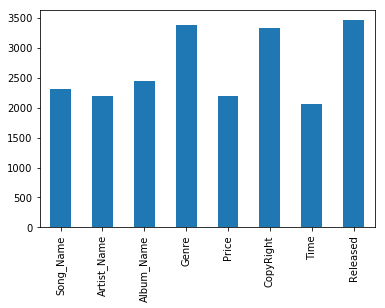

In [36]:
neg_variation_df = pd.DataFrame(data= neg_ri_norms_hybrid,columns=attributes)
neg_variation_df.sum().plot.bar()

In [34]:
pos_ri_hybrid,pos_ri_norms_hybrid = computeRi(hybrid_model.classifier,
                                                    attributes,pos_classifier_hybrid,attribute_len_hybrid,0)

100%|██████████| 4/4 [00:00<00:00,  9.36it/s]


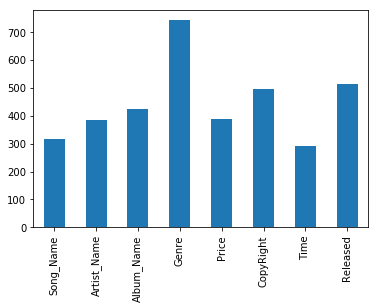

In [35]:
pos_variation_df = pd.DataFrame(data= pos_ri_norms_hybrid,columns=attributes)
pos_variation_df.sum().plot.bar()

## Test robustness on new trained model

In [41]:
model5 = dm.MatchingModel(attr_summarizer='hybrid')
model5.load_state('temp/hybrid_model_5perc.pth')

In [42]:
criticalTimes_forpos = list(map(lambda c:(c[1],c[2]),critical_forPositives['Time']))
criticalTimes_forpos

[('2:51', '4:59'),
 ('5:06', '3:55'),
 ('3:54', '3:57'),
 ('2:51', '3:45'),
 ('5:20', '4:18'),
 ('5:01', '4:18'),
 ('4:27', '4:12'),
 ('4:15', '2:09'),
 ('3:11', '3:52')]

In [43]:
%%capture
old_new_negatives = []
for pair in criticalTimes_forpos:
    old_new_negatives.append(testRobustness(model5,'../../Structured/itunes-amazon/negatives.csv','Time',0,pair))

In [44]:
old_new_negatives

[(405, 399),
 (405, 384),
 (405, 390),
 (405, 387),
 (405, 377),
 (405, 383),
 (405, 378),
 (405, 381),
 (405, 402)]

In [45]:
%%capture
criticalTimes_forneg = list(map(lambda c:(c[1],c[2]),critical_forNegatives['Time']))
old_new_positives = []
for pair in criticalTimes_forneg:
    old_new_positives.append(testRobustness(model5,'../../Structured/itunes-amazon/positives.csv','Time',1,pair))

In [46]:
old_new_positives

[(125, 56), (125, 91), (125, 117), (125, 113)]

### Recompute nearest neighbors

In [ ]:
positives_nn_hybrid = calculate_nearest_neighbors_onAttributes(pos_classifier_hybrid,pos_ids,pos_ri_hybrid,
                                                       neg_classifier_hybrid,neg_ids,attributes,
                                                               attribute_len_hybrid)

In [ ]:
negatives_nn_hybrid = calculate_nearest_neighbors_onAttributes(neg_classifier_hybrid,neg_ids,negatives_ri_hybrid,
                                                        pos_classifier_hybrid,pos_ids,
                                                        attributes,attribute_len_hybrid)

In [ ]:
positives_nn_hybrid.to_csv('temp/positives_nn_extended.csv',index=False)
negatives_nn_hybrid.to_csv('temp/negatives_nn_extended.csv',index=False)

## Add 10% more

In [25]:
newSamplesOnTime = buildNewSamplesForAttribute(critical_forPositives,critical_forNegatives,'Time',
                                              int(positives_len/10),int(negatives_len/10),
                                              train_df.shape[0]+len_validation+len_test)

In [26]:
extended_train_10perc = pd.concat([train_df,newSamplesOnTime])
extended_train_10perc.to_csv('temp/extended_train10.csv',index=False)

In [28]:
train,validation,test = dm.data.process('temp',train='extended_train10.csv',validation='merged_valid.csv',
                                       test='merged_test.csv',left_prefix='ltable_',right_prefix='rtable_')

In [29]:
train.get_raw_table()['label'].value_counts()

0    331
1    141
Name: label, dtype: int64

In [30]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.run_train(train,validation,best_save_path='temp/hybrid_model10.pth',batch_size=16,epochs=20,pos_neg_ratio=3)

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1
Finished Epoch 1 || Run Time:    8.8 | Load Time:    1.3 || F1:  54.16 | Prec:  38.72 | Rec:  90.07 || Ex/s:  46.46

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    0.7 | Load Time:    0.3 || F1:  65.82 | Prec:  50.00 | Rec:  96.30 || Ex/s: 114.64

* Best F1: 65.82278481012658
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2
Finished Epoch 2 || Run Time:    7.1 | Load Time:    1.3 || F1:  75.64 | Prec:  63.46 | Rec:  93.62 || Ex/s:  55.99

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    0.7 | Load Time:    0.3 || F1:  76.06 | Prec:  61.36 | Rec: 100.00 || Ex/s: 114.46

* Best F1: 76.05633802816902
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3
Finished Epoch 3 || Run Time:   11.1 | Load Time:    1.8 || F1:  92.31 | Prec:  87.34 | Rec:  97.87 || Ex/s:  36.42

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    0.8 | Load Time:    0.4 || F1:  76.06 | Prec:  61.36 | Rec: 100.

88.52459016393443

### Test robustness

In [32]:
standard_model = dm.MatchingModel(attr_summarizer='hybrid')
standard_model.load_state('../../models/itunes_amazon_hybrid.pth')

In [35]:
positives = pd.read_csv('../../Structured/itunes-amazon/negatives.csv')
ltime = positives['ltable_Time']
testRobustness(standard_model,'../../Structured/itunes-amazon/negatives.csv','Time',0,(ltime,ltime))

===>  PREDICT Epoch 3
Finished Epoch 3 || Run Time:    1.3 | Load Time:    1.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 3
Finished Epoch 3 || Run Time:    1.3 | Load Time:    1.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



(395, 17)

In [36]:
positives = pd.read_csv('../../Structured/itunes-amazon/negatives.csv')
ltime = positives['ltable_Time']
testRobustness(model,'../../Structured/itunes-amazon/negatives.csv','Time',0,(ltime,ltime))

===>  PREDICT Epoch 5
Finished Epoch 5 || Run Time:    1.3 | Load Time:    1.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

===>  PREDICT Epoch 5
Finished Epoch 5 || Run Time:    1.3 | Load Time:    1.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



(396, 360)

### Recompute rankings

In [11]:
hybrid_model10 = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model10.load_state('temp/hybrid_model10.pth')

In [54]:
neg_classifier_hybrid,neg_ids = return_layer_input('../../Structured/itunes-amazon'
                                                                         ,'negatives',128,hybrid_model10,
                                                                        hybrid_model10.classifier,device=-1)

In [55]:
pos_classifier_hybrid,pos_ids = return_layer_input('../../Structured/itunes-amazon/',
                                                                       'positives',128,hybrid_model10,
                                                                       hybrid_model10.classifier,device=-1)

In [62]:
hybrid_model10 = hybrid_model10.cuda()
classifier_len_hybrid = len(neg_classifier_hybrid[0][0])
attribute_len_hybrid = int(classifier_len_hybrid/len(attributes))

In [63]:
negatives_ri_hybrid,neg_ri_norms_hybrid = computeRi(hybrid_model10.classifier,
                                                    attributes,neg_classifier_hybrid,attribute_len_hybrid,1)

100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


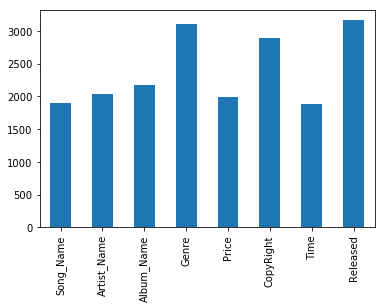

In [65]:
neg_variation_df = pd.DataFrame(data= neg_ri_norms_hybrid,columns=attributes)
neg_variation_df.sum().plot.bar()

In [66]:
pos_ri,pos_ri_norms = computeRi(hybrid_model10.classifier,
                                                    attributes,pos_classifier_hybrid,attribute_len_hybrid,0)

100%|██████████| 4/4 [00:00<00:00,  6.76it/s]


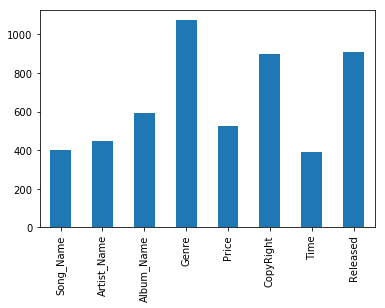

In [67]:
pos_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
pos_variation_df.sum().plot.bar()

### Test robustness

In [68]:
criticalTimes_forpos = list(map(lambda c:(c[1],c[2]),critical_forPositives['Time']))

In [71]:
%%capture
old_new_negatives = []
for pair in criticalTimes_forpos:
    old_new_negatives.append(testRobustness(hybrid_model10,'../../Structured/itunes-amazon/negatives.csv','Time',0,pair))

In [79]:
old_new_negatives

[(396, 335),
 (396, 343),
 (396, 357),
 (396, 291),
 (396, 267),
 (396, 257),
 (396, 357),
 (396, 347),
 (396, 367)]

In [12]:
%%capture
criticalTimes_forneg = list(map(lambda c:(c[1],c[2]),critical_forNegatives['Time']))
old_new_positives = []
for pair in criticalTimes_forneg:
    old_new_positives.append(testRobustness(hybrid_model10,'../../Structured/itunes-amazon/positives.csv','Time',1,pair))

In [80]:
old_new_positives

[(130, 9), (130, 88), (130, 122), (130, 105)]